## Recover temporal latent causal factors with simulated data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import ltcl
from ltcl.modules.flow import TemporalMBDFlow
from ltcl.datasets.sim_dataset import SimulationDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [4]:
train_dataset = SimulationDataset("train")
training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = SimulationDataset("val")
validation_generator = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [5]:
flow = TemporalMBDFlow(input_size = 4, 
                       lags = 2,
                       batch_norm = True)
flow = flow.to(device)

In [9]:
max_epochs = 50
optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)

In [ ]:
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    running_loss = 0
    for batch_sample in training_generator:
        batch_x = batch_sample["x"]
        batch_y = batch_sample["y"]
        # Transfer to GPU
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # Model computations
        loss = -flow.log_prob(batch_x, batch_y)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
    print(f"Training loss: {running_loss/len(training_generator)}")
    # Validation
    running_loss = 0
    with torch.set_grad_enabled(False):
        for batch_sample in validation_generator:
            # Transfer to GPU
            batch_x = batch_sample["x"]
            batch_y = batch_sample["y"]
            # Transfer to GPU
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            loss = -flow.log_prob(batch_x, batch_y)
            running_loss += loss.item()
        print(f"Validation loss: {running_loss/len(validation_generator)}")

In [29]:
flow.dconv.step_func.wt_func.w[0]

tensor([[ 0.0856, -0.1105,  0.0456, -0.1840],
        [ 0.0579,  0.3119,  0.0132, -0.2144],
        [ 0.0989,  0.4178,  0.0784, -0.0980],
        [-0.0204,  0.1507, -0.0098,  0.1536]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [25]:
A = flow.dconv.step_func.w0_func.weight_inverse().detach().cpu().numpy()

In [30]:
W2 = flow.dconv.step_func.wt_func.w[0].detach().cpu().numpy()
W1 = flow.dconv.step_func.wt_func.w[1].detach().cpu().numpy()

In [31]:
B2 = - W2.dot(A)
B1 = - W1.dot(A)

In [33]:
import numpy as np

In [34]:
BB2 = np.load("/home/cmu_wyao/projects/data/W2.npy")
BB1 = np.load("/home/cmu_wyao/projects/data/W1.npy")

In [36]:
B2

array([[-0.07045263,  0.09503389,  0.00644745,  0.15047832],
       [-0.06034965, -0.19848113, -0.17987344,  0.19141246],
       [-0.12586184, -0.23649803, -0.2963099 ,  0.09434471],
       [-0.00234012, -0.104367  , -0.06301729, -0.12482481]],
      dtype=float32)

In [35]:
BB2

array([[-0.11602794, -0.08464393, -0.02603337,  0.06588003],
       [-0.12051216, -0.07185142,  0.1075287 ,  0.06400988],
       [-0.04957278, -0.12478562,  0.02026224, -0.06289764],
       [ 0.06227155,  0.04937641,  0.08963022, -0.11207826]],
      dtype=float32)

In [64]:
np.corrcoef(np.concatenate((B2[:,1:2], BB2),axis=1), rowvar=False)[0,1:]

array([-0.17801579,  0.14434665, -0.60607826,  0.37672233])

In [63]:
np.corrcoef(np.concatenate((B1[:,1:2], BB1),axis=1), rowvar=False)[0,1:]

array([-0.97430806,  0.97199143, -0.85896381,  0.40588093])

In [147]:
b = np.concatenate((B1,B2), axis=0)
bb = np.concatenate((BB1,BB2), axis=0)

In [148]:
C = np.zeros((4,4))
for i in range(4):
    C[i] = -np.abs(np.corrcoef(np.concatenate((b[:,i:i+1], bb),axis=1), rowvar=False)[0,1:])

In [149]:
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)

In [152]:
bb = bb[:, col_ind]

In [154]:
bb[:, 1] = -bb[:, 1]

In [155]:
np.corrcoef(np.concatenate((b[:,1:2], bb),axis=1), rowvar=False)[0,1:]

array([-0.43107343,  0.76536712,  0.765327  ,  0.38826191])

In [137]:
pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)

In [156]:
true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)

Text(0, 0.5, 'Ground truth weight')

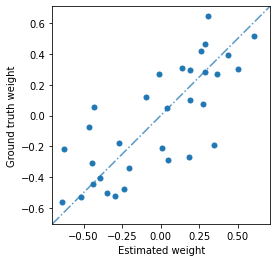

In [160]:
fig, ax = plt.subplots()
ax.scatter(pred, true, s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, '-.', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Estimated weight")
ax.set_ylabel("Ground truth weight")

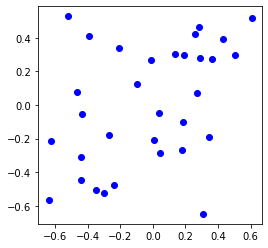

In [111]:
fig = plt.figure(figsize=(4,4))
plt.scatter(pred, true, color="b")

In [74]:
np.corrcoef(np.concatenate((b[:,3:4], bb),axis=1), rowvar=False)[0,1:]

array([-0.04054914, -0.21470176,  0.01769078,  0.76646166])

In [ ]:
def rho(x, y):
    np.linalg.norm(x)

In [37]:
B1

array([[ 0.05507505,  0.02031636,  0.12683484,  0.31659666],
       [ 0.05208791, -0.26221636, -0.2948519 ,  0.2266472 ],
       [ 0.10151416, -0.21882255, -0.42727652,  0.18028   ],
       [ 0.00909519,  0.15609388,  0.19063202,  0.07266236]],
      dtype=float32)

In [38]:
BB1

array([[ 0.01711187,  0.11909086, -0.01244408,  0.12207896],
       [ 0.09664682, -0.17948285,  0.13917136,  0.09270462],
       [ 0.06878981, -0.22737175, -0.01418805, -0.04447889],
       [-0.06609106,  0.18667027, -0.17076305,  0.07220882]],
      dtype=float32)

In [47]:
np.corrcoef(B1, BB1, rowvar=False)[4:,4:]

array([[ 1.        , -0.90199503,  0.92980249, -0.24544727],
       [-0.90199503,  1.        , -0.71495755,  0.60499074],
       [ 0.92980249, -0.71495755,  1.        ,  0.11594784],
       [-0.24544727,  0.60499074,  0.11594784,  1.        ]])

In [34]:
y = torch.rand(16, 4, 2).cuda()

In [39]:
import numpy as np

In [146]:
d = np.load("/home/cmu_wyao/projects/data/499.npz")

In [147]:
d["x"].shape

(128, 80, 4)

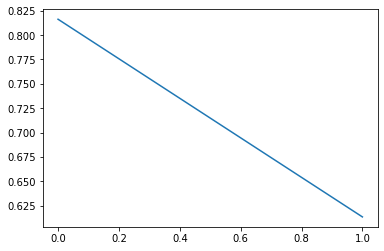

In [150]:
plt.plot(d["y"][2,:,1])

In [ ]:
torch.uni

In [ ]:
torch.bmm

In [37]:
flow.sample(y, 128)

RuntimeError: The size of tensor a (128) must match the size of tensor b (16) at non-singleton dimension 0

In [14]:
x = torch.rand(16, 8, 2)
y = torch.rand(16, 4, 2)

In [19]:
flow.log_prob(x, y)

tensor(-98.6351, grad_fn=<MeanBackward0>)

In [10]:
sum_log_abs_det_jacobians

tensor([13.7777,  8.7662, 12.9915,  3.5598,  6.7196,  5.2455,  5.3330,  9.8531,
         7.6980,  6.1647,  8.2872, 11.3447,  8.8890, 11.8513, 11.4018, 10.5304],
       grad_fn=<AddBackward0>)

In [6]:
e.shape, z.shape, sum_log_abs_det_jacobians.shape

(torch.Size([16, 8, 2]), torch.Size([16, 8, 2]), torch.Size([16]))

In [7]:
xx = flow.inverse(z, y)

In [10]:
sum_log_abs_det_jacobians

tensor([ -3.9754,   1.4525, -11.8307,   4.9286,  -7.9111,  -6.1972,   2.7244,
        -12.6433,  -8.9205,  -2.1613,  -2.2704,  -4.0597,   1.5329,  -0.9711,
         -3.9992,  -6.1606], grad_fn=<AddBackward0>)